# CMIP6 data

This notebook shows how to access CMIP6 data from the cloud

## Import modules and libraries

*First, let's make sure the Python env is correct to run this notebook*:

In [1]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2025/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"), 
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    check_up_env()

/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/tmpdg6rcx30/utils.py:66: UserWarning: 
Running on your own environment
Make sure to have all necessary packages installed
See: https://github.com/obidam/ds2-2025/blob/main/binder/environment.yml
  warnings.warn("\nRunning on your own environment\nMake sure to have all necessary packages installed\nSee: https://github.com/obidam/ds2-2025/blob/main/binder/environment.yml")


In [2]:
import sys
import gcsfs
import xarray as xr
import intake
import zarr
import pandas as pd
# print(gcsfs.__version__)
# print(xr.__version__)
# print(intake.__version__)
# print(zarr.__version__)

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# 
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Read the full CMIP6 catalog

In [3]:
df_full = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_full.sample(10)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
250159,ScenarioMIP,MOHC,UKESM1-0-LL,ssp245,r4i1p1f2,EdayZ,utendnogw,gnz,gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...,NaN,20190815
136427,PAMIP,CCCma,CanESM5,pdSST-futAntSIC,r41i1p2f1,Amon,rsut,gn,gs://cmip6/CMIP6/PAMIP/CCCma/CanESM5/pdSST-fut...,NaN,20190429
241005,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp370,r7i1p1f1,Omon,icfriver,gn,gs://cmip6/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-H...,NaN,20190710
470350,CMIP,EC-Earth-Consortium,EC-Earth3-AerChem,amip,r1i1p1f1,Amon,prc,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200910
293265,CMIP,NIMS-KMA,KACE-1-0-G,historical,r2i1p1f1,Amon,prc,gr,gs://cmip6/CMIP6/CMIP/NIMS-KMA/KACE-1-0-G/hist...,NaN,20190920
462556,CMIP,NCC,NorCPM1,historical,r8i1p1f1,day,vas,gn,gs://cmip6/CMIP6/CMIP/NCC/NorCPM1/historical/r...,NaN,20200724
274063,DCPP,MIROC,MIROC6,dcppA-hindcast,r7i1p1f1,Amon,ta,gn,gs://cmip6/DCPP/MIROC/MIROC6/dcppA-hindcast/s1...,1981.0,20190821
191609,DCPP,CCCma,CanESM5,dcppA-hindcast,r3i1p2f1,Amon,prw,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,1985.0,20190429
494301,PAMIP,NCAR,CESM1-WACCM-SC,piSST-piSIC,r53i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/piS...,NaN,20201012
155301,DCPP,CCCma,CanESM5,dcppA-hindcast,r20i1p2f1,Amon,zg,gn,gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...,2007.0,20190429


### Make a subset of it

In [4]:
# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & institution_id == 'CNRM-CERFACS' & experiment_id == 'historical'")
# df = df_full.query('institution_id == "CNRM-CERFACS" & member_id=="r1i1p1f2" & source_id=="CNRM-CM6-1"')

# df = df_full.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'thetao' & experiment_id == 'abrupt-4xCO2'")

# df = df.query("source_id=='CNRM-CM6-1-HR' & variable_id=='thetao'") # Horizontal resolution up to 1/4 deg
# df = df.query("source_id=='CNRM-ESM2-1' & variable_id=='thetao'") # Horizontal resolution up to 1deg
df = df.query("source_id=='CNRM-ESM2-1' & (variable_id=='thetao' | variable_id=='so')") # Horizontal resolution up to 1deg

# df = df.sort_values('version')
df = df.sort_values('member_id')
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
406634,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r10i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200117
406642,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r10i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200117
430447,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r11i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20200408
44083,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
44013,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
51505,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r2i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51514,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r2i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51428,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r3i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
50556,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r3i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125
51214,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r4i1p1f2,Omon,so,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190125


## Read some data (1 row of the catalog)

In [5]:
def open_cmip6(df_row):
    # get the path to zarr store
    zstore = df.zstore.values[-1]
    print(zstore)
    
    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(zstore)

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    print("Size of this dataset:", ds.nbytes/1e9,"Gb")

    return ds

ds = open_cmip6(df.iloc[0])
ds

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/


/Users/gmaze/git/github/euroargodev/argopy/argopy/utils/lists.py:28: UserWarning: An error occurred while loading the ERDDAP data fetcher, it will not be available !
<class 'ModuleNotFoundError'>
No module named 'erddapy'
  warnings.warn(
/Users/gmaze/git/github/euroargodev/argopy/argopy/utils/lists.py:40: UserWarning: An error occurred while loading the ArgoVis data fetcher, it will not be available !
<class 'ModuleNotFoundError'>
No module named 'erddapy'
  warnings.warn(
/Users/gmaze/git/github/euroargodev/argopy/argopy/utils/lists.py:56: UserWarning: An error occurred while loading the GDAC data fetcher, it will not be available !
<class 'ModuleNotFoundError'>
No module named 'erddapy'
  warnings.warn(
/Users/gmaze/git/github/euroargodev/argopy/argopy/utils/lists.py:81: UserWarning: An error occurred while loading the ERDDAP index fetcher, it will not be available !
<class 'ModuleNotFoundError'>
No module named 'erddapy'
  warnings.warn(
/Users/gmaze/git/github/euroargodev/argopy/a

Size of this dataset: 63.22679556 Gb


<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, lev: 75, axis_nbounds: 2,
                  time: 1980)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds   (lev, axis_nbounds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(4, 75, 294, 362), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_historical_r9i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/8e969929-c070-414d-9eca-f4c99b7be8b7...
    variable_id:            thetao
    variant_label:          r9i1p1f2
    xios_commit:            1442-shuffle
    netcdf_tracking_ids:    hdl:21.14100/8e969929-c070-414d-9eca-f4c99b7be8b7...
    version_id:             v20200117

### Play with it

In [6]:
# Compute size of the full df selection:
total_size = 0 # Gb
for index, row in df.iterrows():
    ds = open_cmip6(row)
    total_size += ds.nbytes/1e9
print("Size of the selection of datasets:", total_size, "Gb")    

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb
gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb
gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb
gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb
gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb
gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb
gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v20200117/
Size of this dataset: 63.22679556 Gb
gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r9i1p1f2/Omon/thetao/gn/v2020011

In [7]:
sst = ds['thetao'].sel(lev=0, method='nearest')
sst

<xarray.DataArray 'thetao' (time: 1980, y: 294, x: 362)>
dask.array<getitem, shape=(1980, 294, 362), dtype=float32, chunksize=(4, 294, 362), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lev      float64 0.5058
    lon      (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: y, x
Attributes:
    cell_measures:       area: areacello volume: volcello
    cell_methods:        area: mean where sea time: mean
    description:         Diagnostic should be contributed even for models usi...
    history:             none
    interval_operation:  1800 s
    interval_write:      1 month
    long_name:           Sea Water Potential Temperature
    online_operation:    average
    standard_name:       sea_water_potential_temperature
    units:               degC

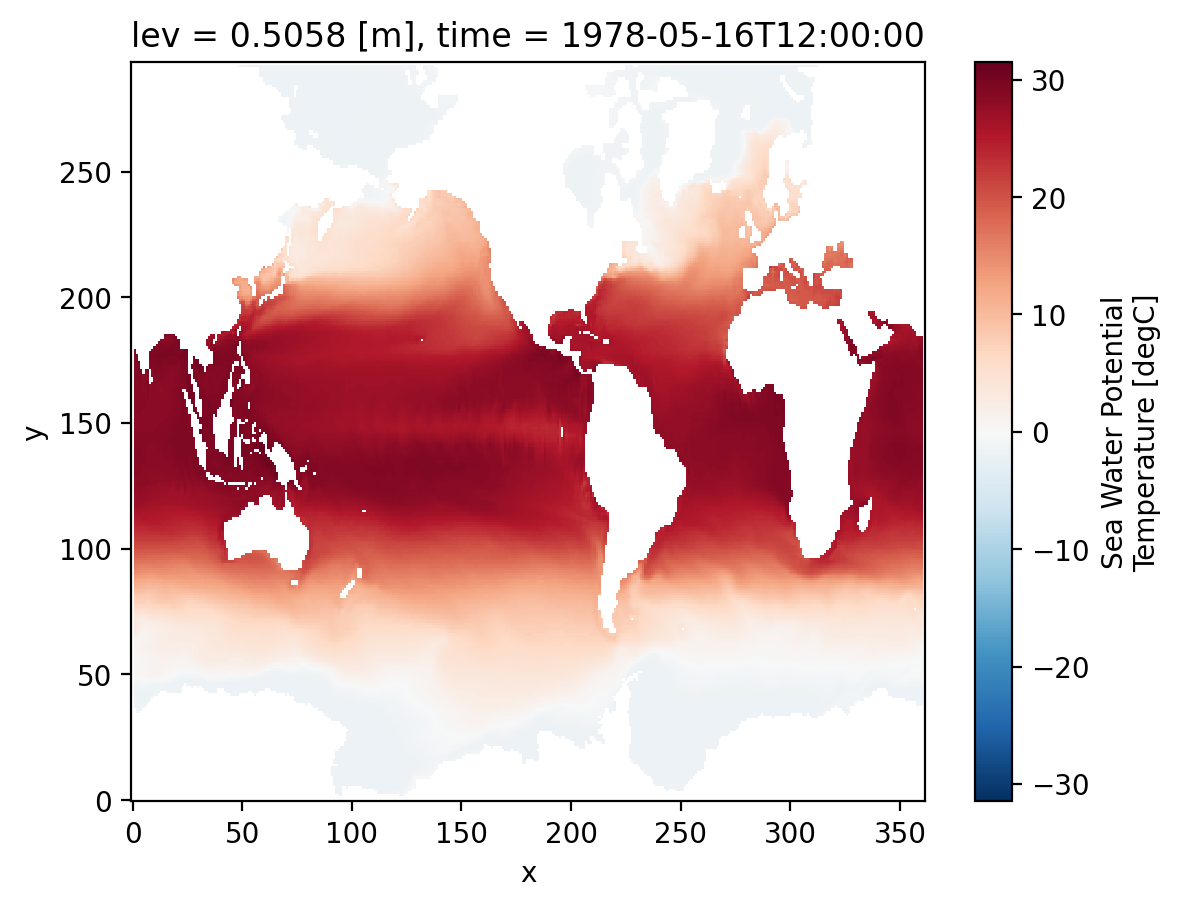

In [8]:
sst.sel(time='1978-05-28T12:00:00', method='nearest').plot()

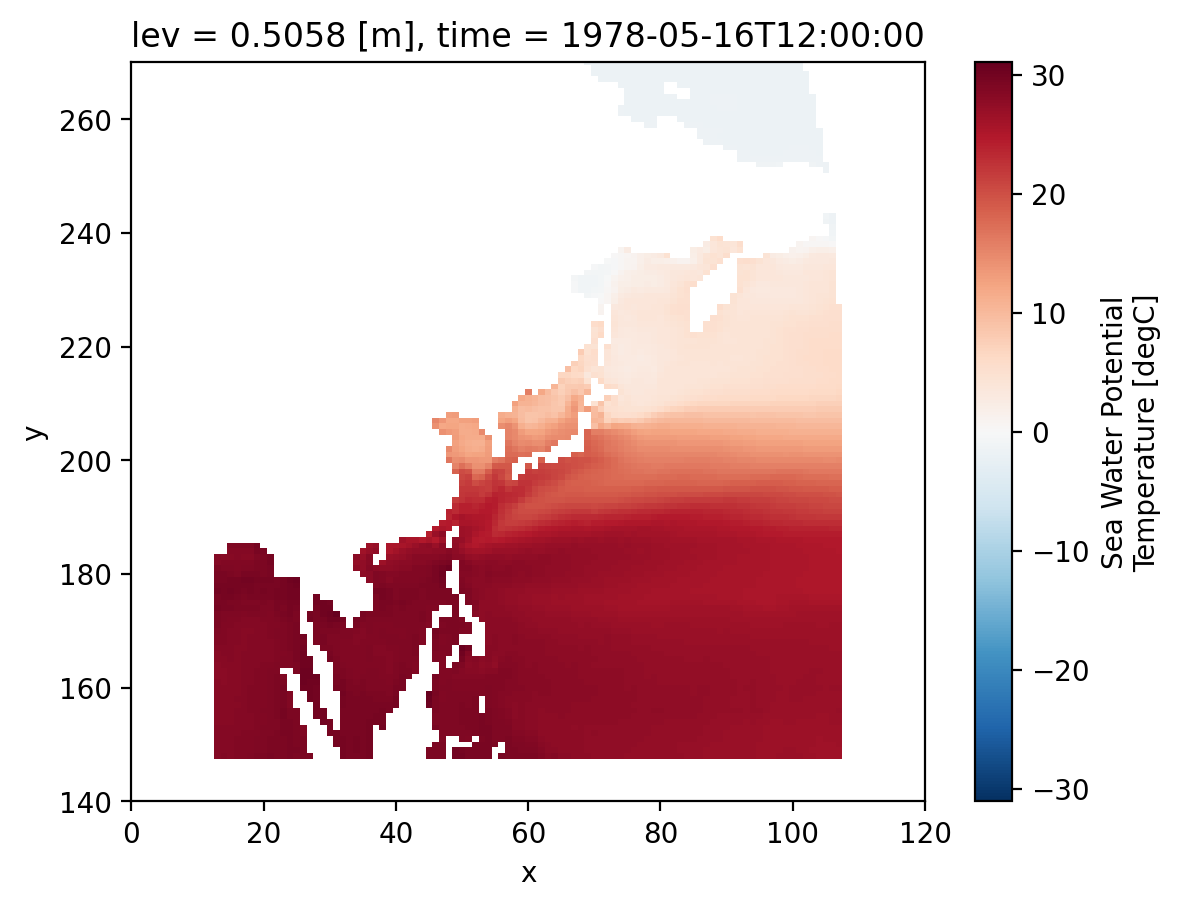

In [9]:
sst.where(sst['lat']>=0).where(sst['lon']>=360-275).sel(time='1978-05-28T12:00:00', method='nearest').plot(xlim=[0, 120], ylim=[140, 270])

### Horizontal resolution of the grid

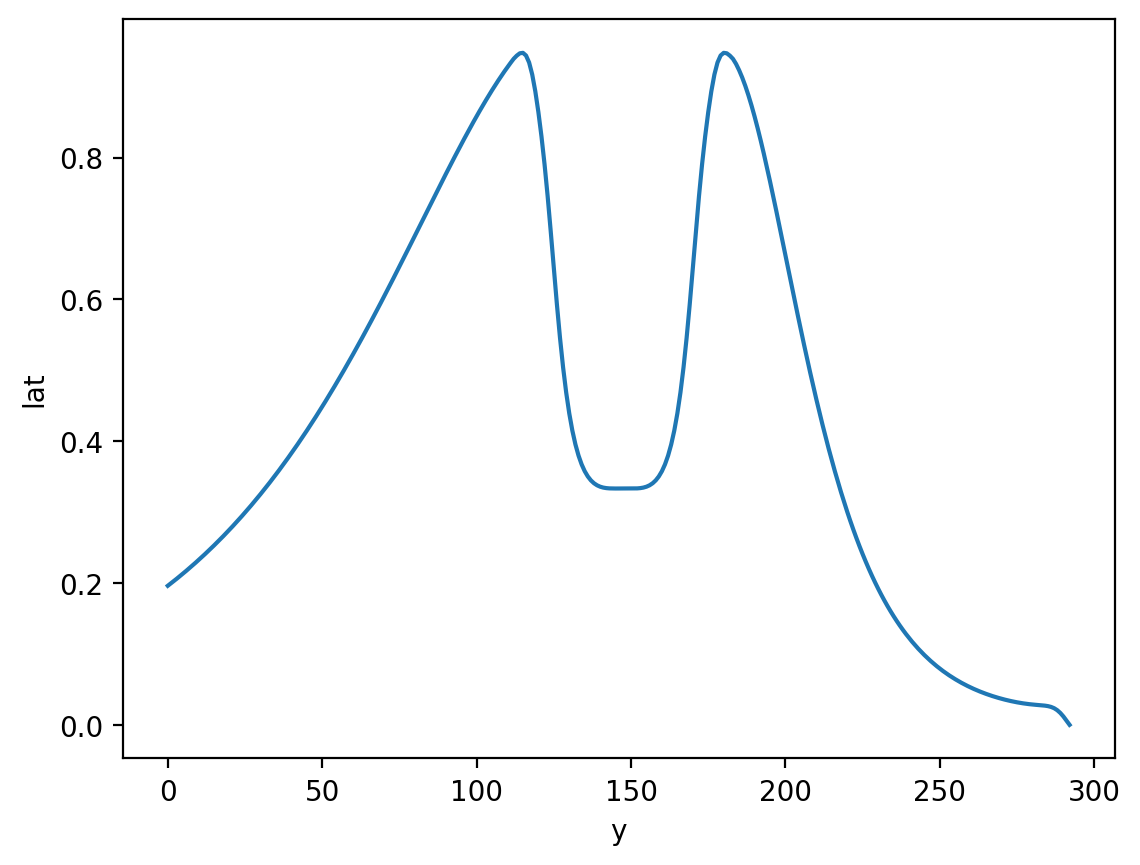

In [10]:
ds['lat'].isel(x=0).diff('y').plot()

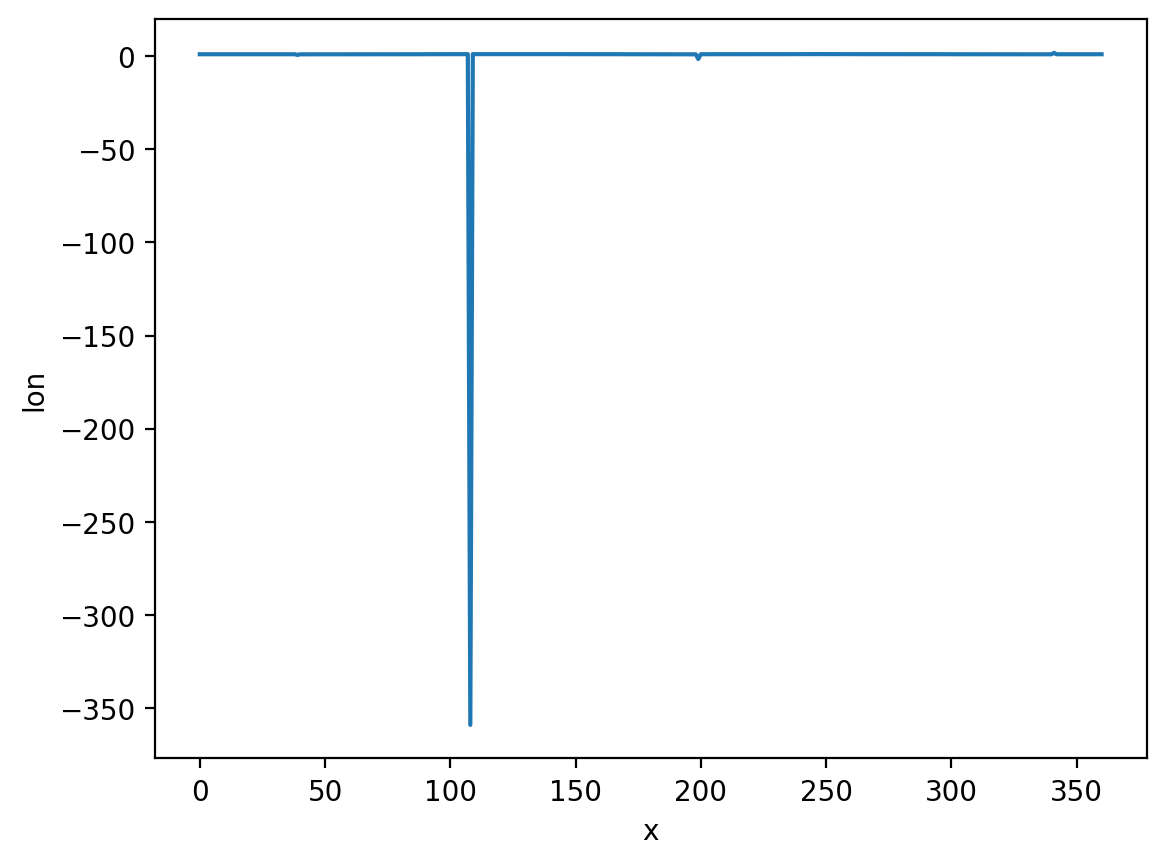

In [11]:
ds['lon'].isel(y=0).diff('x').plot()